In [335]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3
from datetime import datetime
import matplotlib.animation as animation
from copy import deepcopy as copy
from src import convert
from IPython.display import display as disp, Math, Latex
import scipy.signal
from src import plot
def print_latex(code):
  """Print a LaTeX string."""
  disp(Math(code))
from numba import njit

---

# 1. Introduction

### Initialization

In [336]:

DT = 600 # in seconds
T = 2500 # number of time steps
t = np.arange(T)*DT

### Body class

In [337]:
# Class definition

class Body():
    all = []

    def __init__(self, name, pos, vel, acc, gm, color):
        self.name = name
        self.pos = pos
        self.initial_pos = pos
        self.vel = vel
        self.initial_vel = vel
        self.acc = acc
        self.initial_acc = acc
        self.gm = gm
        self.pos_dyn = np.zeros((T,3))
        self.pos_dyn[0] = self.pos
        self.vel_dyn = np.zeros((T,3))
        self.vel_dyn[0] = self.vel
        self.acc_dyn = np.zeros((T,3))
        self.acc_dyn[0] = self.acc
        self.color = color
        Body.all.append(self)

### Body definition

In [ ]:
mimas = Body(
    name = 'Mimas',
    pos  = np.array([-1.813557294137345E+05, 3.492995866271013E+04, 5.054192147215439E+03]),
    vel  = np.array([-2.445920348718876E+00, 1.416736794928916E+01, 1.873213454946043E-02]),
    acc  = np.array([0,0,0]),
    gm   = 2.503489,
    color = "tab:blue")

thetys = Body(
    name = 'Thetys',
    pos  = np.array([-1.889929479196472E+05, -2.260662471700913E+05, -7.020174976279632E+02]),
    vel  = np.array([8.706811449016753E+00, -7.280896606319645E+00, -2.143307520131600E-01]),
    acc  = np.array([0,0,0]),
    gm   = 41.21,
    color = "tab:orange")

titan = Body(
    name = 'Titan',
    pos  = np.array([2.956179324256932E+05, 1.212611254175863E+06, -6.683800852915738E+02]),
    vel  = np.array([-5.322398770209340E+00, 1.190373084298060E+00, -3.847254100240810E-02]),
    acc  = np.array([0,0,0]),
    gm   = 8978.14,
    color = "tab:green")

saturn = Body(
    name = 'Saturn',
    pos  = np.array([0,0,0]),
    vel  = np.array([0,0,0]),
    acc  = np.array([0,0,0]),
    gm   = 37931206.2,
    color = "tab:red")

saturn.R = 60268 # km
saturn.J2 = 1.629e-2

# Initial acceleration
# for body in [mimas, thetys, titan]:
#     body.acc = body.compute_acceleration(saturn)

### Cartesian to orbital elements conversion

In [ ]:
def compute_orbital_dyn(bodies=Body.all):
    for body in bodies:
        body.orb_dyn = np.zeros((T,6))
        for t in range(0,T):
            body.orb_dyn[t] = convert.cartesian_to_orbital(body.pos_dyn[t], body.vel_dyn[t], saturn.gm + body.gm)

---

# 2. Integration

In [ ]:
@njit(fastmath=True)
def acceleration(r:np.ndarray, gm:float, flattened:bool=False) -> float:
    
    d = np.linalg.norm(r)
    acc = -gm * r / d**3

    if flattened:
        R = 60268 # km
        J2 = 1.629e-2
        flat_acc = np.zeros(3) - 3/2 * gm * J2 * R**2 * r / d**7
        flat_acc[0] *=   r[0]**2 +   r[1]**2 - 4*r[2]**2
        flat_acc[1] *=   r[0]**2 +   r[1]**2 - 4*r[2]**2
        flat_acc[2] *= 3*r[0]**2 + 3*r[1]**2 - 2*r[2]**2
        acc += flat_acc
        
    return acc

### Runge-Kutta integrator

In [ ]:
# Acceleration function : f(t,y) -> (v,a)     with y = (p,v)
def acceleration_rk(t, y, body, bodies=[mimas, thetys, titan], perturbated=False, saturn_flattened=False) -> np.array:
    pos = y[:3]
    vel = y[3:]

    # Compute acceleration caused by saturn
    if body is not saturn:
        acc = acceleration(pos, saturn.gm + body.gm, flattened=saturn_flattened)

    # Compute acceleration caused by other bodies
    if perturbated:
        for other_body in bodies:
            if (other_body is body): continue
            acc += acceleration(other_body.pos - pos, other_body.gm)

    return np.concatenate((vel, acc))

# Runge kutta 4th order : rk4(t,dt,y,evaluate) -> y     with y = (p,v)
def rk4(t,dt,y,evaluate, body, bodies=[mimas, thetys, titan], perturbated=False, saturn_flattened=False) -> np.array:

    k1 = evaluate(t, y,                      body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k2 = evaluate(t + 0.5*dt, y + 0.5*k1*dt, body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k3 = evaluate(t + 0.5*dt, y + 0.5*k2*dt, body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    k4 = evaluate(t + dt, y + dt*k3,         body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
    
    y_new = y + (1./6.)*(k1+ 2.*k2 + 2.*k3 + k4) * dt

    return y_new

In [ ]:

# Evolve using Runge Kutta method
def evolve_rk(bodies=[mimas, thetys, titan], T=T, perturbated=False, saturn_flattened=False):

    for body in bodies:
        body.pos = np.copy(body.initial_pos)
        body.vel = np.copy(body.initial_vel)
        body.acc = np.copy(body.initial_acc)

    for t in range(1,T):    
        for body in bodies:

            y = np.concatenate((body.pos, body.vel))
            y = rk4(t*DT, DT, y, acceleration_rk, body=body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)

            body.pos = y[:3]
            body.vel = y[3:]

            body.pos_dyn[t] = np.copy(body.pos)
            body.vel_dyn[t] = np.copy(body.vel)
            
    compute_orbital_dyn(bodies)

### Leap Frog integrator

In [ ]:
def acceleration_lf(body, bodies=[mimas, thetys, titan], perturbated=False, saturn_flattened=False):
    
    # Compute acceleration caused by saturn
    if body is not saturn:
        acc = acceleration(body.pos, saturn.gm + body.gm, flattened=saturn_flattened)

    # Compute acceleration caused by other bodies
    if perturbated:
        for other_body in bodies:
            if (other_body is body): continue
            acc += acceleration(other_body.pos - body.pos, other_body.gm)

    return acc

In [ ]:
# Evolve using Leap Frog method
def evolve_lf(bodies=[mimas, thetys, titan], T=T, perturbated=False, saturn_flattened=False):

    for body in bodies:
        body.pos = np.copy(body.initial_pos)
        body.vel = np.copy(body.initial_vel)
        body.acc = np.copy(body.initial_acc)

    for t in range(1,T):
        for body in bodies:
            body.pos = body.pos + body.vel * DT + body.acc/2 * DT**2
            body.vel =            body.vel      + body.acc/2 * DT
            body.acc = acceleration_lf(body, bodies=bodies, perturbated=perturbated, saturn_flattened=saturn_flattened)
            body.vel =            body.vel      + body.acc/2 * DT

            body.pos_dyn[t] = np.copy(body.pos)
            body.vel_dyn[t] = np.copy(body.vel)

    compute_orbital_dyn(bodies)

In [ ]:
# Compute evolution
evolve_rk(bodies=[mimas, thetys, titan])

### Plot position evolution

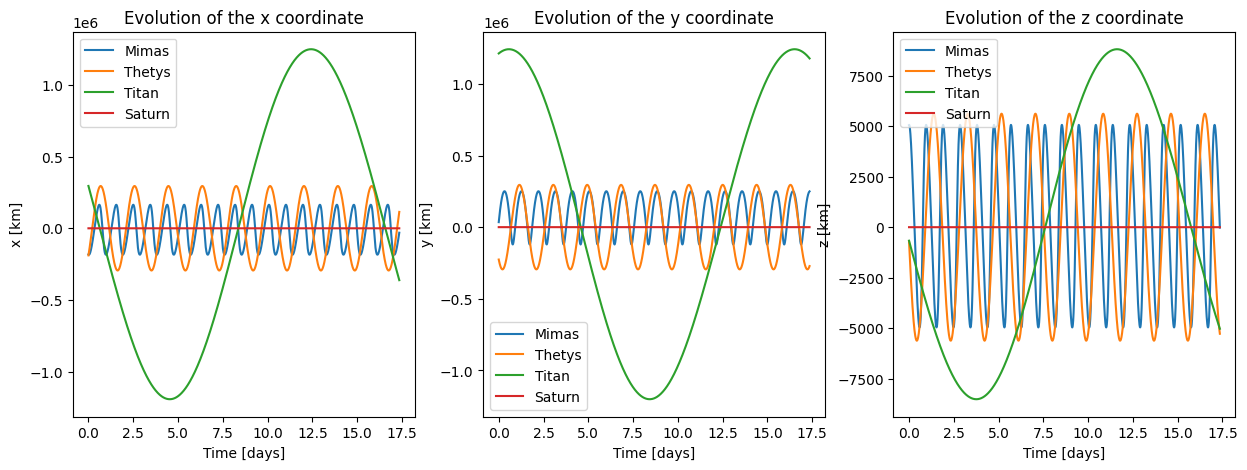

In [ ]:
plot.pos_dyn(Body.all, T, DT)

### 3D representation of orbits

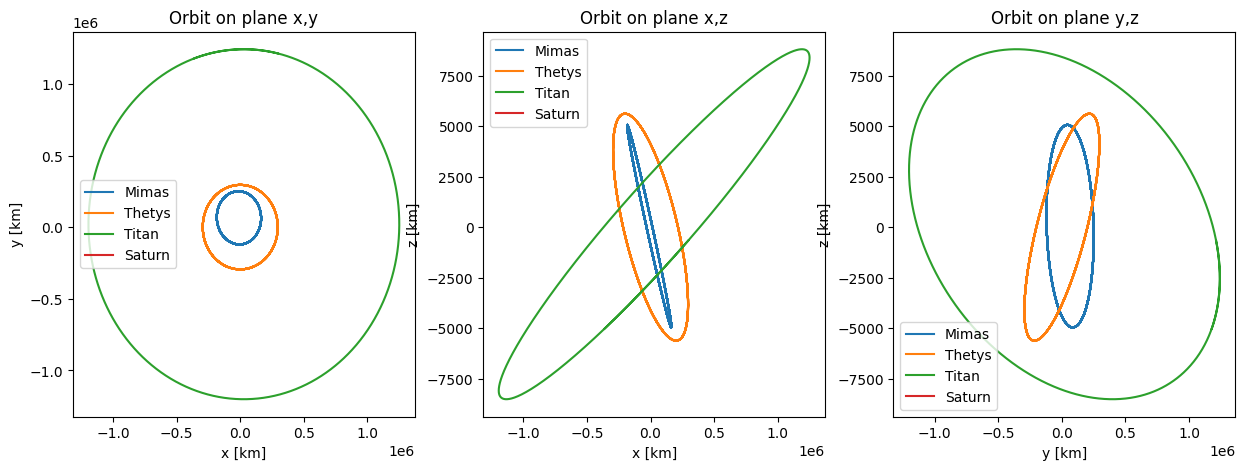

In [ ]:
plot.orbits(Body.all)

### Plot velocity evolution

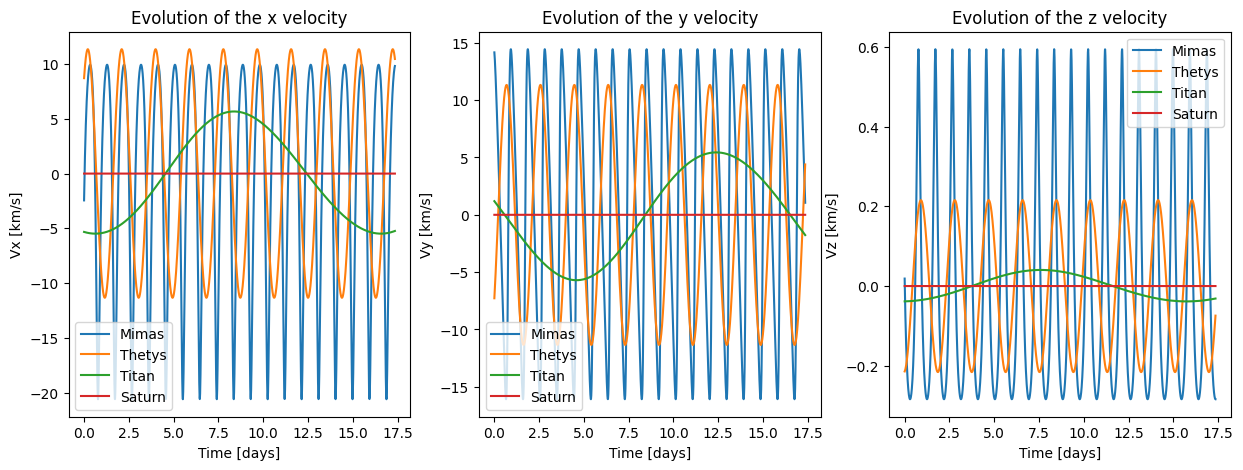

In [ ]:
plot.vel_dyn(Body.all, T, DT)

---

# 3. Switching from cartesian to keplerian elements, and conversely

### Convert to orbital elements

In [ ]:
def orbital_element_to_string(ell):
    ell = [round(i,3) for i in ell]
    return r"a="+str(ell[0])+r"\quad e="+str(ell[1])+r"\quad i="+str(ell[2])+r"\quad \Omega="+str(ell[3])+r"\quad \varpi="+str(ell[4])+r"\quad \lambda="+str(ell[5])

In [ ]:
def print_orbital_elements(bodies=[mimas, thetys, titan]):
    for body in bodies:
        for t in range(0,T):
            if t == 0:
                ell = orbital_element_to_string(body.orb_dyn[t])
                string = r"\text{" + body.name + r"'s initial keplerian elements:\quad}"+ell
            if t == T-1:
                ell = orbital_element_to_string(body.orb_dyn[t])
                print_latex(string + r"\\ \text{" + body.name + r"'s final keplerian elements:\quad}"+ell)

In [ ]:
print_orbital_elements([mimas, thetys, titan])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

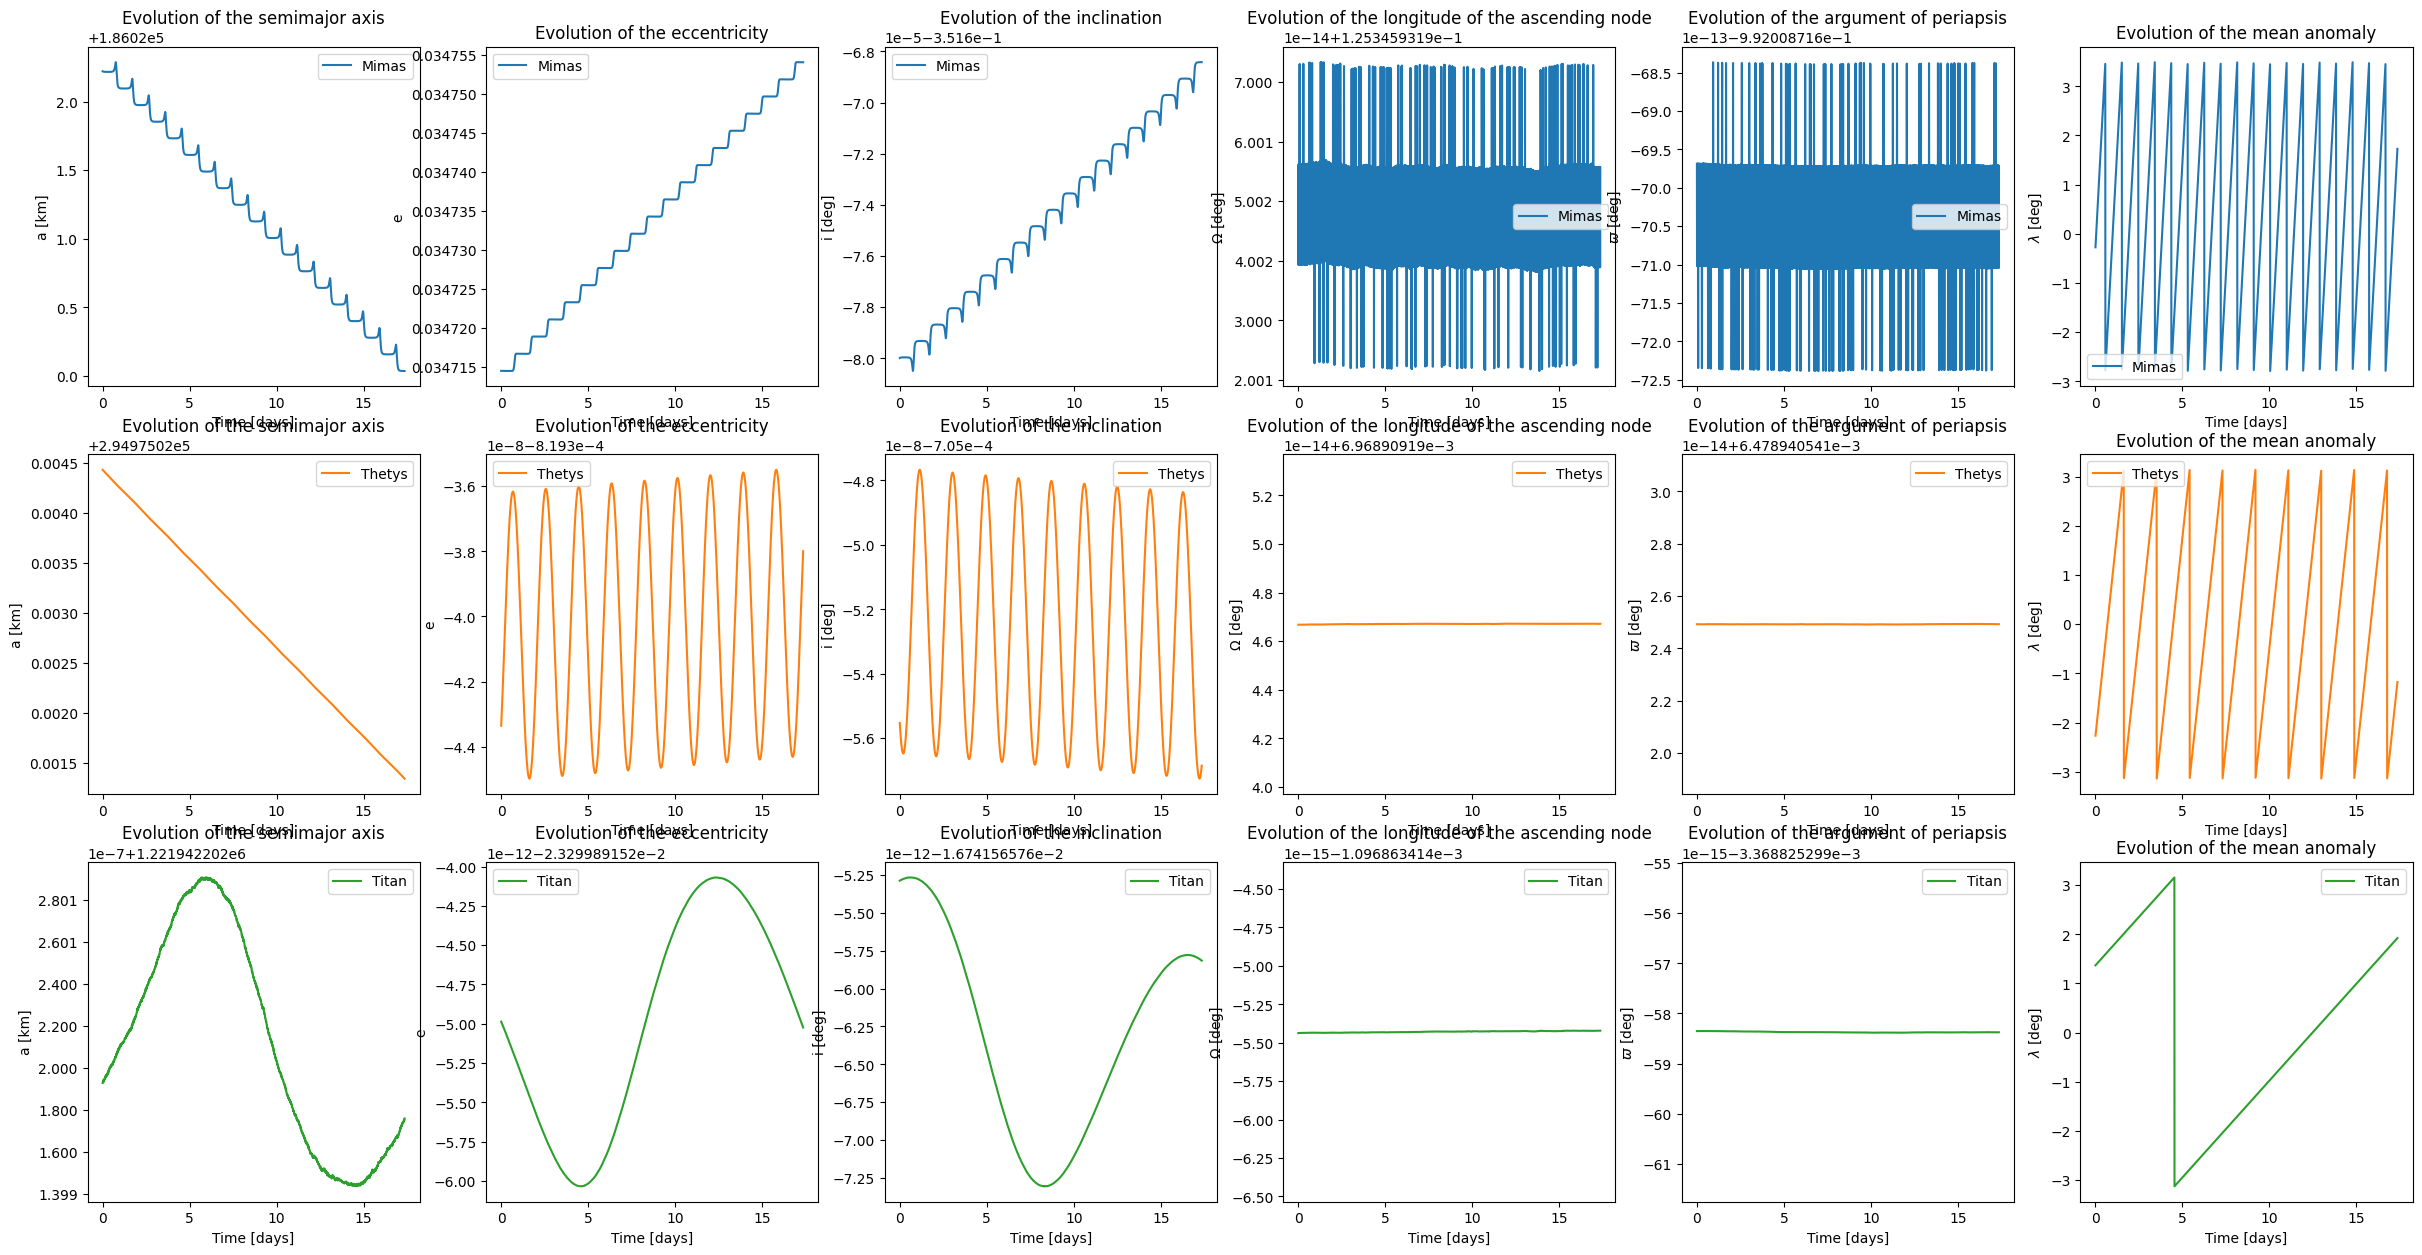

In [ ]:
plot.orbital_elements([mimas, thetys, titan], T, DT)

When the system is not perturbated, we see that the orbital elements are conserved.

---

# 4. Including the mutual perturbations

### Adding perturbations

In [ ]:
evolve_rk(bodies=[mimas, thetys, titan], perturbated=True)

### Plot position evolution

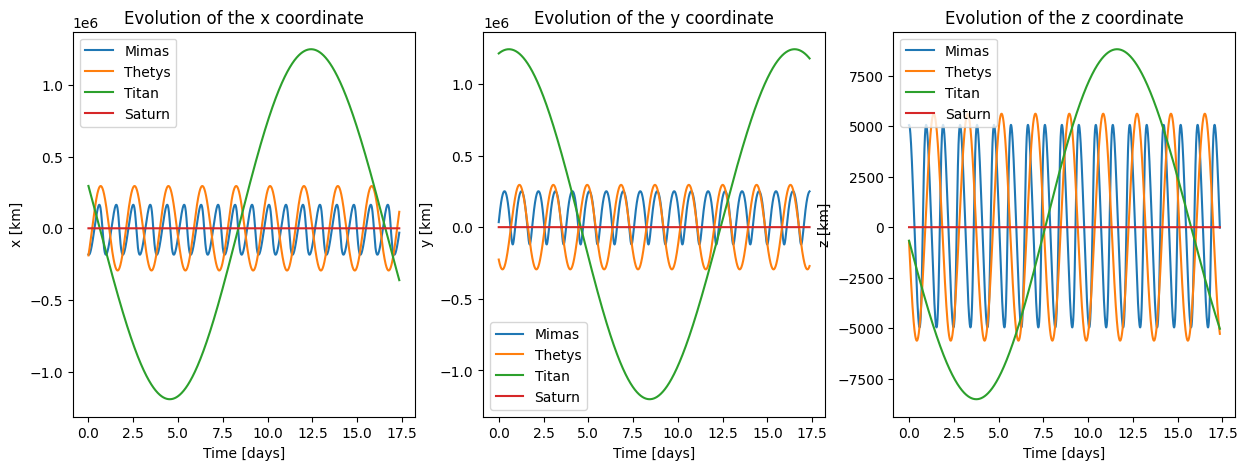

In [ ]:
plot.pos_dyn(Body.all, T, DT)

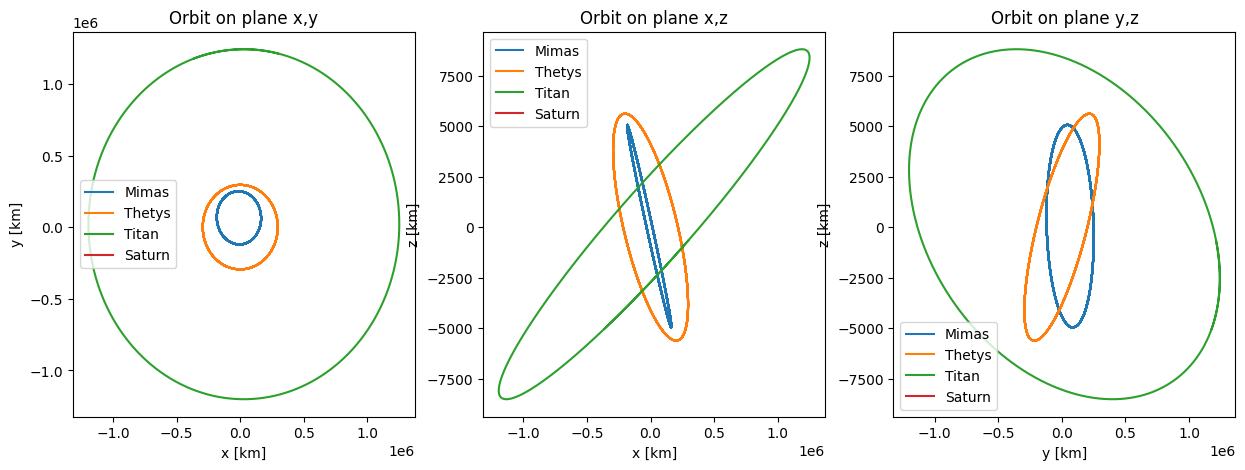

In [ ]:
plot.orbits(Body.all)

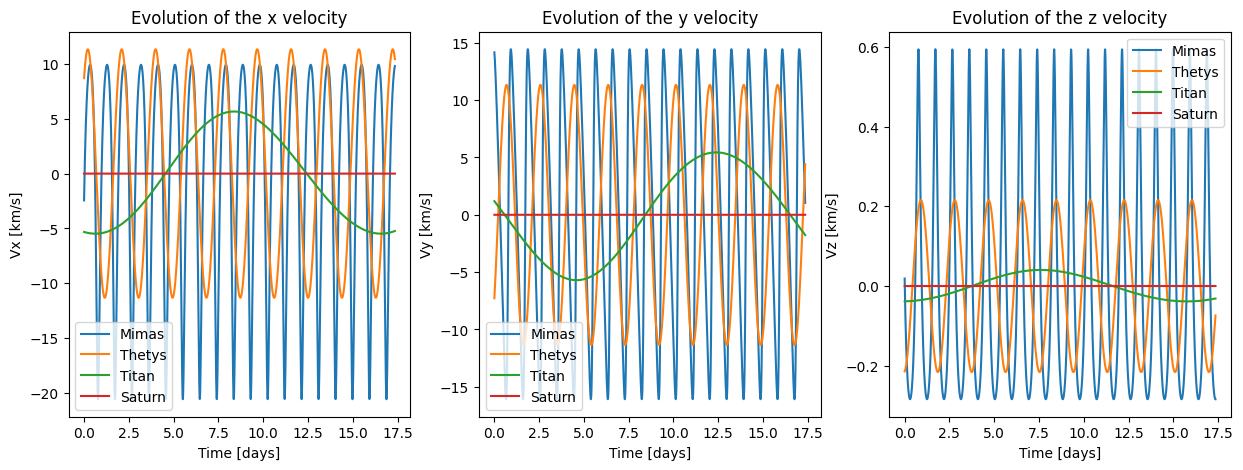

In [ ]:
plot.vel_dyn(Body.all, T, DT)

### Orbital elements

In [ ]:
print_orbital_elements([mimas, thetys, titan])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

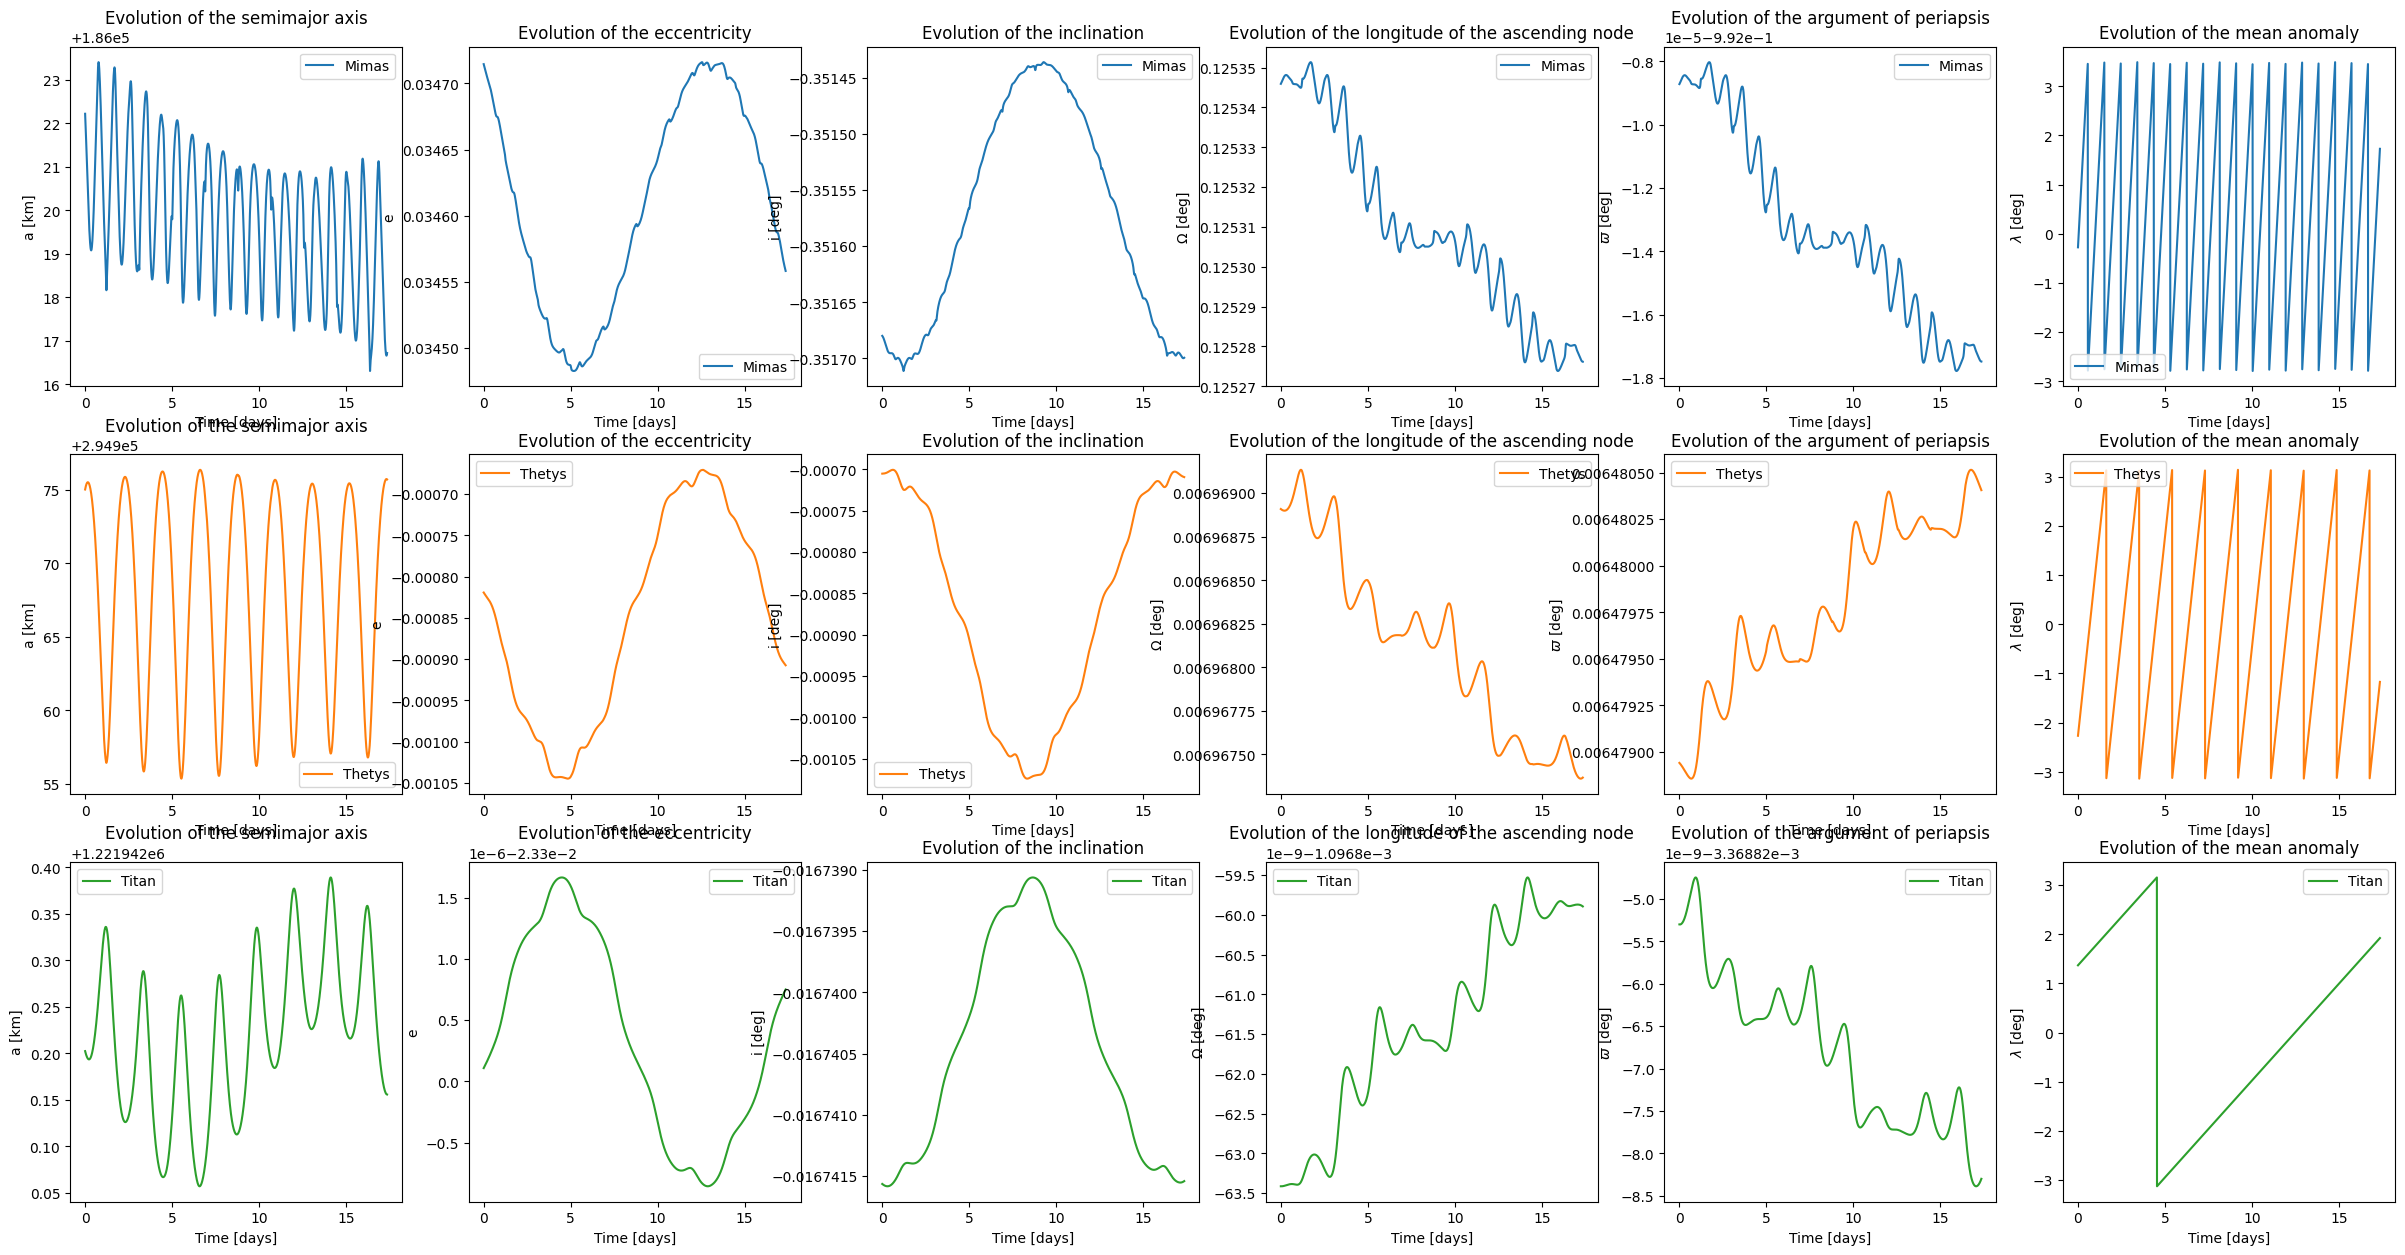

In [ ]:
plot.orbital_elements([mimas, thetys, titan], T, DT)

---

# 5. The flattening of Saturn

In [ ]:
evolve_rk(bodies=[mimas, thetys, titan], perturbated=True, saturn_flattened=True)

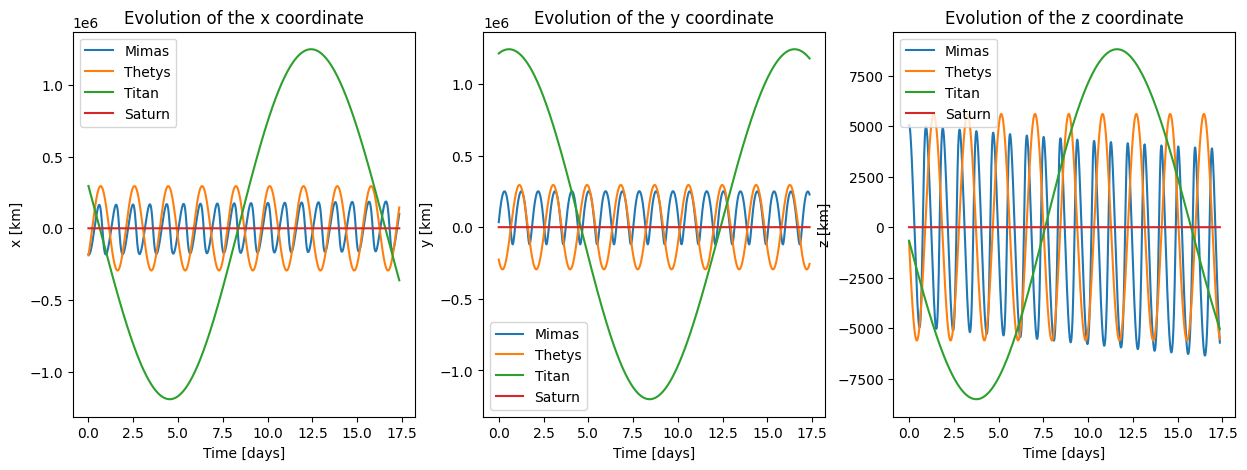

In [ ]:
plot.pos_dyn(Body.all, T, DT)

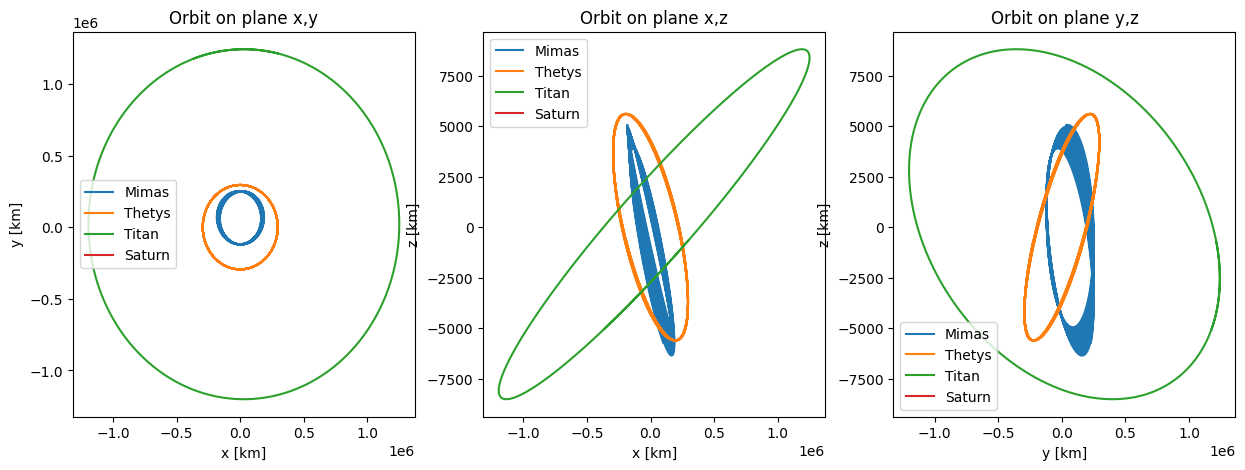

In [ ]:
plot.orbits(Body.all)

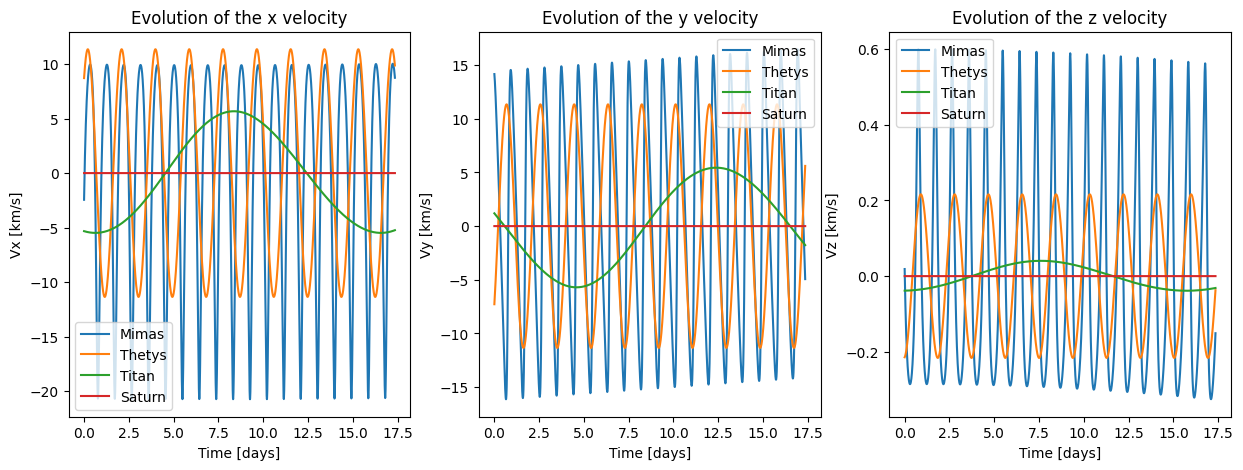

In [ ]:
plot.vel_dyn(Body.all, T, DT)

In [ ]:
print_orbital_elements([mimas, thetys, titan])

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

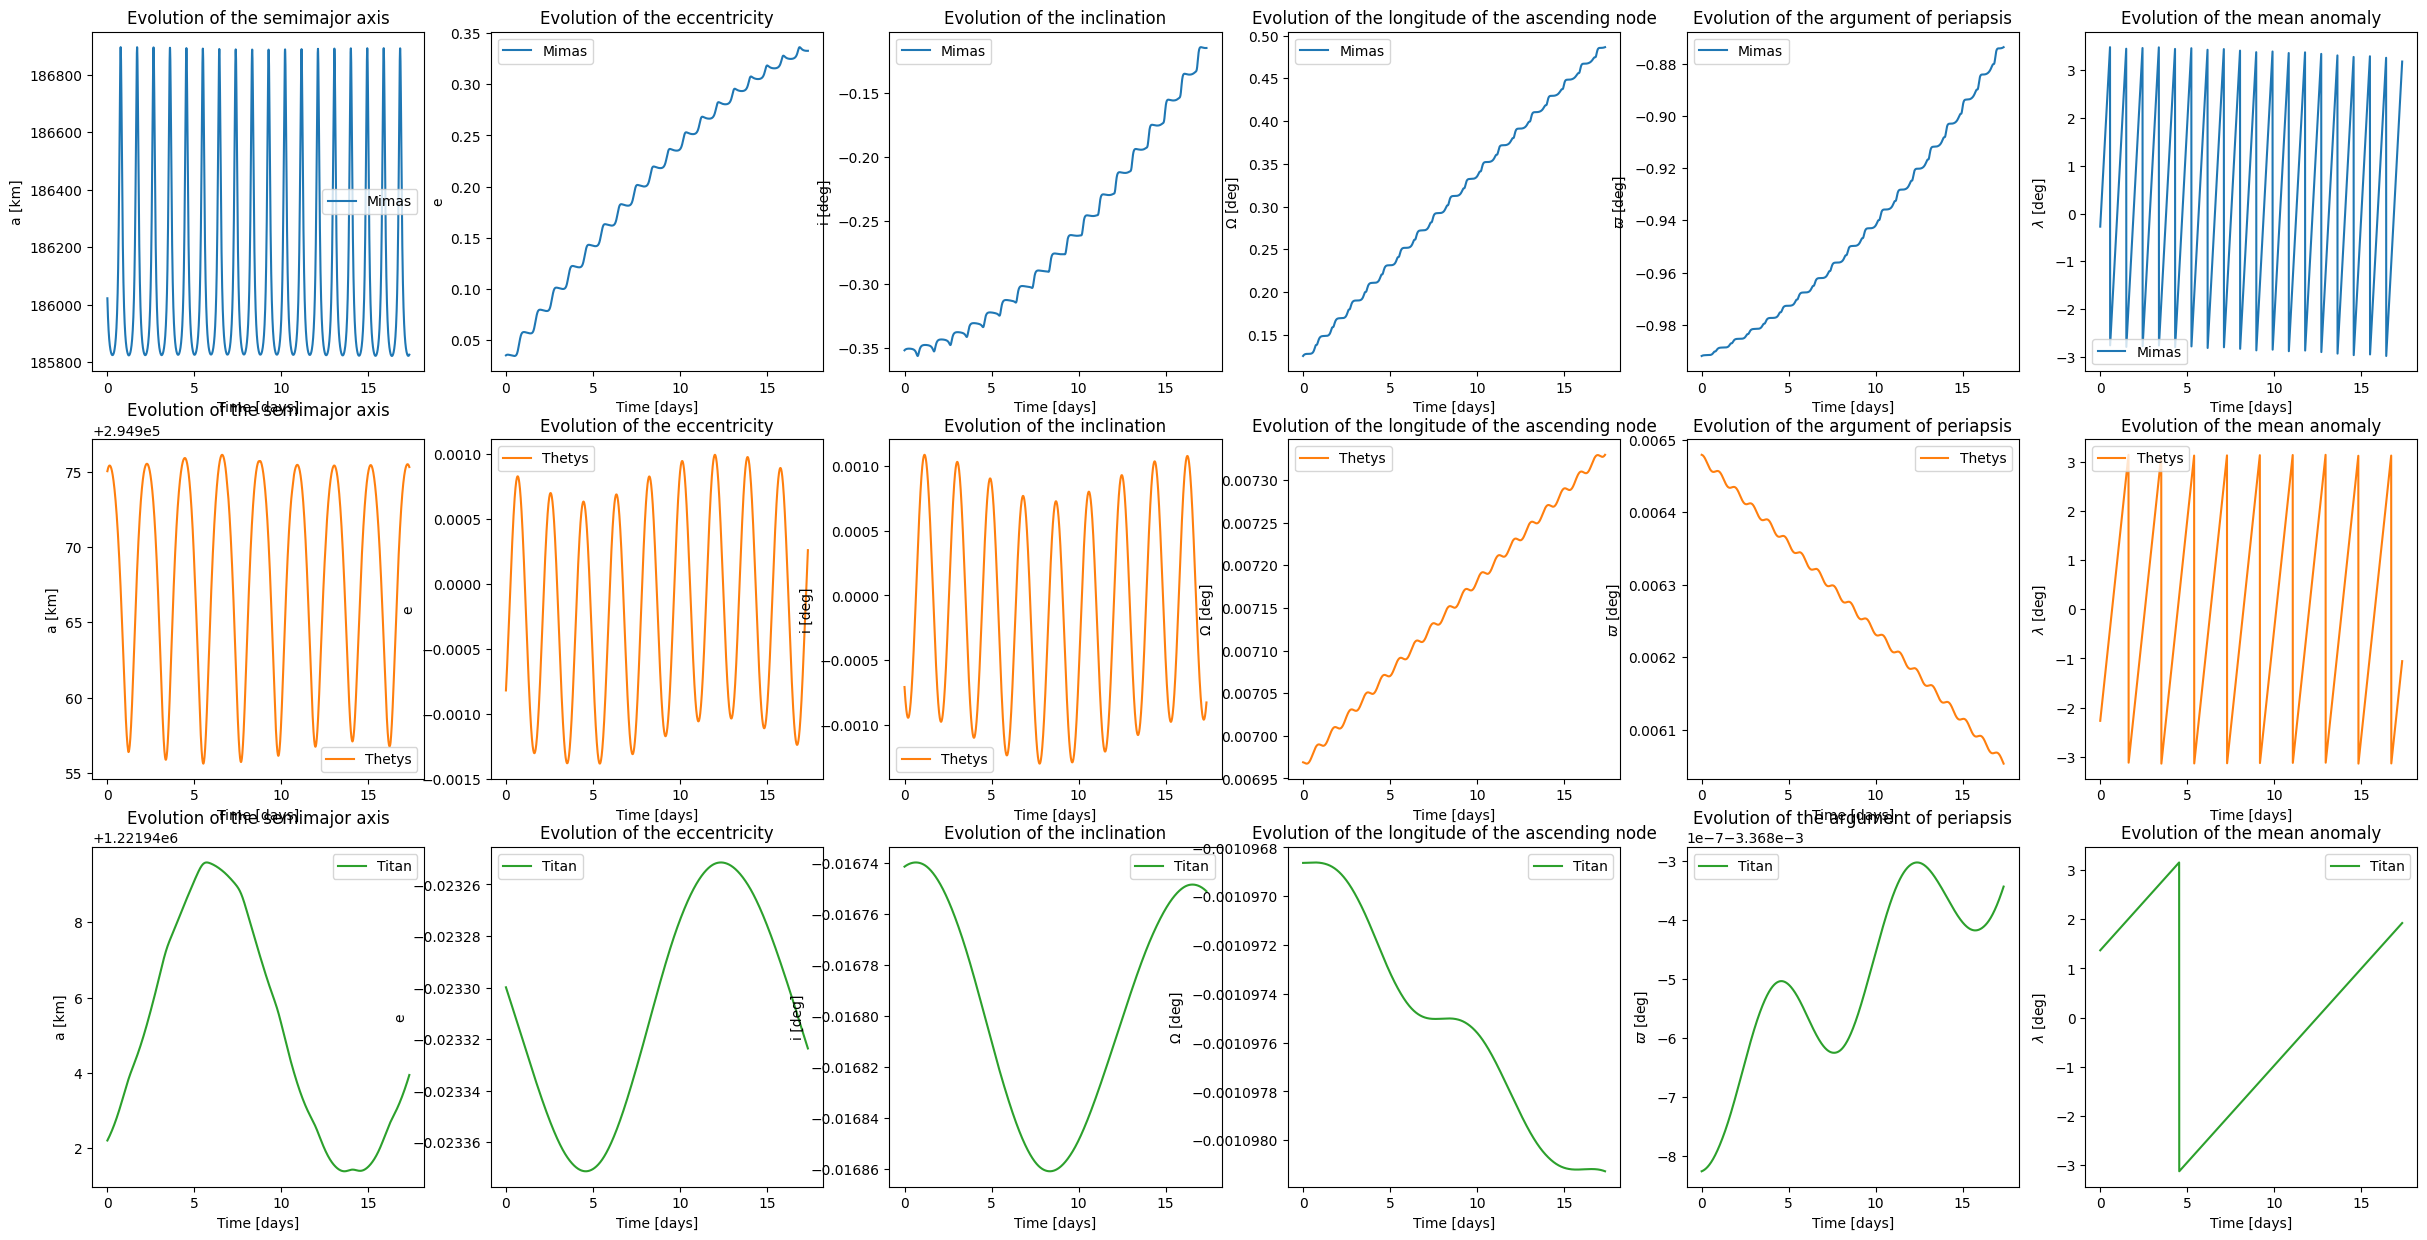

In [ ]:
plot.orbital_elements([mimas, thetys, titan], T, DT)

In [ ]:
@njit(fastmath=True, parallel=True)
def central_diff(f, dt):
    newf = np.zeros(len(f))
    for i in range(1,len(f)-1):
        newf[i] = (f[i+1] - f[i-1]) / (2*dt)
    newf[0] = (f[1] - f[0]) / dt
    newf[-1] = (f[-1] - f[-2]) / dt
    return newf

In [ ]:
@njit(parallel=True)
def get_period(sig, t):
    maxima = []
    for i in np.arange(len(sig)-2)+1:
        if sig[i-1] < sig[i] > sig[i+1]:
            maxima.append(t[i])
    return (maxima[-1] - maxima[0]) / (len(maxima) - 1)

In [ ]:
for body in [mimas, thetys, titan]:
    body.T = get_period(mimas.pos_dyn[:,0], t)
    body.n = 2*np.pi / body.T
    print(body.name, body.T, body.n)

Mimas 81352.94117647059 7.723365887350179e-05
Thetys 81352.94117647059 7.723365887350179e-05
Titan 81352.94117647059 7.723365887350179e-05


0.01629 7.723365887350179e-05 60268 186895.10364489708
0.01629 7.723365887350179e-05 60268 294976.11144208536
0.01629 7.723365887350179e-05 60268 1221949.587048332


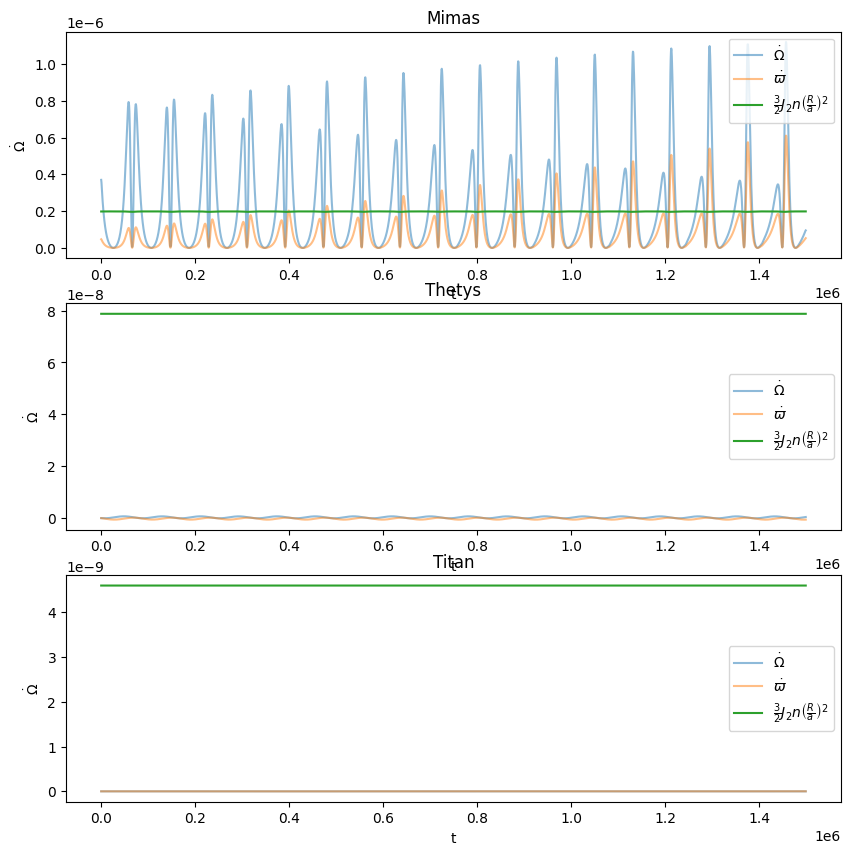

In [ ]:
fig, axs = plt.subplots(3, 1, figsize=(10,10))

for i, body in enumerate([mimas, thetys, titan]):
    body.omega_dot_dyn = central_diff(body.orb_dyn[:,3], DT)
    body.varpi_dot_dyn = central_diff(body.orb_dyn[:,4], DT)

    axs[i].plot(t, body.omega_dot_dyn, label=r"$\dot{\Omega}$", alpha=0.5)
    axs[i].plot(t, body.varpi_dot_dyn, label=r"$\dot{\varpi}$", alpha=0.5)
    print(saturn.J2, body.n, saturn.R, np.amax(body.orb_dyn[:,0]))
    # axs[i].plot(t, 3/2*saturn.J2 * body.n * (saturn.R / body.orb_dyn[:,0])**2, label=r"$\frac{3}{2}J_2 n \left(\frac{R}{a}\right)^2$")
    axs[i].set_title(body.name)
    axs[i].set_xlabel("t")
    axs[i].set_ylabel(r"$\dot{\Omega}$")
    axs[i].legend()

plt.show()
    
    

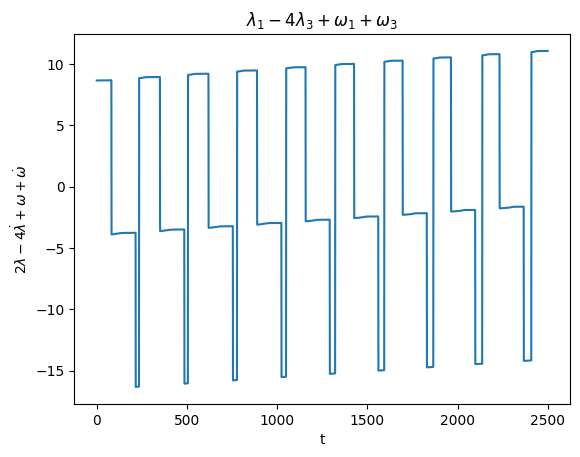

In [ ]:
plt.plot(2*mimas.orb_dyn[:,5] - 4*thetys.orb_dyn[:,5] + mimas.orb_dyn[:,3] + thetys.orb_dyn[:,3])
plt.title(r"$\lambda_1 - 4\lambda_3 + \omega_1 + \omega_3$")
plt.xlabel("t")
plt.ylabel(r"$2\lambda - 4\dot{\lambda} + \omega + \dot{\omega}$")
plt.show()
